# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# Imports from our package
# from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
# from lightautoml.tasks import Task

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
# функция ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [11]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [12]:
test['brand'].value_counts(normalize=True)

BMW         0.436864
MERCEDES    0.330341
AUDI        0.232795
Name: brand, dtype: float64

In [13]:
train['brand'].value_counts(normalize=True)

BMW         0.419784
MERCEDES    0.343310
AUDI        0.236905
Name: brand, dtype: float64

Как видим, распределение марок автомобилей в тренировочном и тестовом датасете одинаковое. Так что с этим все ок

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [14]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [15]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

In [16]:
# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

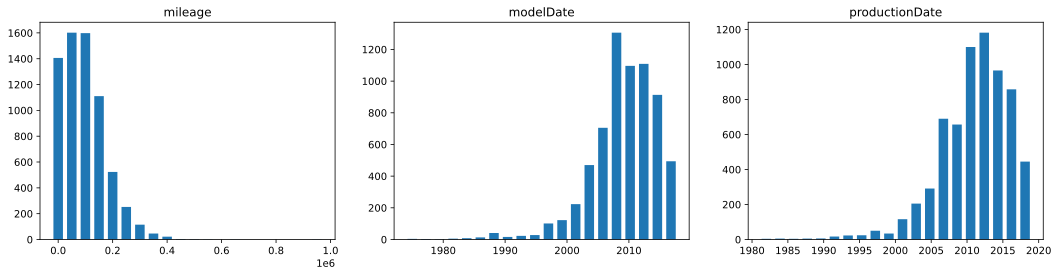

In [17]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Проверим наши признаки при помощи логарифмирования.

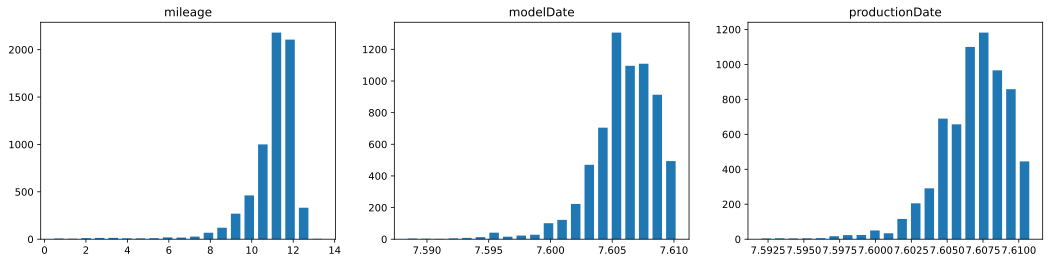

In [18]:
visualize_distributions({
    'mileage': np.log(train['mileage']+1).dropna(),
    'modelDate': np.log(train['modelDate']+1).dropna(),
    'productionDate': np.log(train['productionDate']+1).dropna()
})

Как видим сильно это не помогает.

Посмотрим на содержание отдельных столбцов.

In [19]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


Переведм **engineDisplacement** и **enginePower** в числовые признаки.

С признаком **name** можно будет поработать в NLP.

**Владение** - просто удаляем - много пропусков.

**Владельцы** - категориальный признак.

**vehicleConfiguration** - ничего особенного, просто конкатенация типа кузова коробки и двигателя.

In [20]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

import string
print(string.punctuation)

spec_chars = string.punctuation + '«»—…’‘”“©'
print(spec_chars)

# Зададим функцию для удаления спец символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»—…’‘”“©


In [21]:
english_stopwords_ = english_stopwords + ['лс','квт']

In [22]:
# Зададим функцию для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n',' ').replace('\t',' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]
    
    return filtered_token_text

In [23]:
train['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))

0           [sedan, automatic]
1            [sedan, variator]
2           [sedan, automatic]
3            [sedan, variator]
4         [liftback, variator]
                 ...          
6677        [sedan, automatic]
6678        [sedan, automatic]
6679        [sedan, automatic]
6680        [sedan, automatic]
6681    [limousine, automatic]
Name: vehicleConfiguration, Length: 6682, dtype: object

# PreProc Tabular Data

In [24]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [25]:
#категориальные признаки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                        'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 
                        'Владельцы', 'ПТС', 'Привод', 'Руль']

#числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'how_old', 'mile_per_year',
                     'engineDisplacement_N','enginePower_N']

In [26]:
# Напишем наши классы обработки данных
class DatasetProcessing(BaseEstimator, TransformerMixin):
    
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_ = X.copy() # работаем с копией
        
        
        X_.drop(['description','sell_id','Владение'], axis = 1, inplace=True)
    
        # ################### Feature Engineering ####################################################

        # Возвраст авто
        X_['how_old'] = X_['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)

        # Пробег за год (не работал ли в такси?)
        X_['mile_per_year'] = X_['mileage'] / X_['how_old']

        # Сделаем числовой признка из engineDisplacement
        X_['engineDisplacement_N'] = X_['engineDisplacement'].apply(lambda x:
                                                                               x[:x.find(' LTR')])

        X_['engineDisplacement_N'] = X_['engineDisplacement_N'].apply(lambda x: float(x) if len(x)<4 else 0)

        # Сделаем числовой признка из enginePower
        X_['enginePower_N'] = X_['enginePower'].apply(lambda x: int(x[:x.find(' N12')]))

        # Нормализация данных
        scaler = MinMaxScaler()
        for column in numerical_features:
            X_[column] = np.log(X_[column] + 1)
            X_[column] = scaler.fit_transform(X_[[column]])[:,0]

        # Вытащим все из name
        X_['name'] = X_['name'].apply(lambda x: text_tokenizer(x))

        name_dummy = X_['name'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)

        # Вытащим все из vehicleConfiguration
        X_['vehicleConfiguration'] = X_['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))

        vehicleConfiguration_dummy = X_['vehicleConfiguration'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)

        # Объединим данные с дамисами
        X_ = pd.concat([X_, name_dummy], axis=1)
        X_ = pd.concat([X_, vehicleConfiguration_dummy], axis=1)

        # Label Encoding
        for column in categorical_features:
            X_[column] = X_[column].astype('category').cat.codes

        # One-Hot Encoding
        X_ = pd.get_dummies(X_, columns=categorical_features, dummy_na=False)
        
        return X_

In [27]:
# Проверям обработку данных
df_preproc = DatasetProcessing().fit_transform(data)

In [28]:
df_preproc.head()

,mileage,modelDate,name,productionDate,vehicleConfiguration,sample,price,how_old,mile_per_year,engineDisplacement_N,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
0,0.919998,0.273217,[лс],0.238563,"[wagondoors, automatic]",0,0.0,0.914915,0.827965,0.683527,...,0,0,1,0,1,1,0,0,1,0
1,0.679963,0.834995,"[xdrive, лс, wd]",0.817210,"[coupe, automatic]",0,0.0,0.502073,0.661250,0.683527,...,1,0,0,0,1,0,0,1,1,0
2,0.863427,0.710809,"[xi, лс, wd]",0.686256,"[coupe, automatic]",0,0.0,0.649561,0.836531,0.617688,...,0,0,1,0,1,0,0,1,1,0
3,0.853889,0.710809,[лс],0.660027,"[sedan, automatic]",0,0.0,0.672591,0.818356,0.541682,...,0,1,0,0,1,1,0,0,1,0
4,0.715778,0.938200,"[xdrive, лс, wd]",0.973926,"[sedan, automatic]",0,0.0,0.135348,0.830535,0.541682,...,1,0,0,0,1,0,0,1,1,0


In [29]:
# Удаляем лишние признаки
df_preproc.drop(['name','vehicleConfiguration'], axis = 1, inplace=True)

In [30]:
df_preproc.sample(4)

,mileage,modelDate,productionDate,sample,price,how_old,mile_per_year,engineDisplacement_N,enginePower_N,'activehybrid',...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.829686,0.896948,0.869500,1,1590000.0,0.418183,0.866669,0.541682,0.528676,0,...,1,0,0,0,1,0,0,1,1,0
4273,0.763680,0.876307,0.895626,1,3100000.0,0.366726,0.804296,0.541682,0.528676,0,...,1,0,0,0,1,0,0,1,1,0
3362,0.778972,0.876307,0.869500,1,3750000.0,0.418183,0.805970,0.922912,0.919349,0,...,0,0,1,0,1,0,0,1,1,0
2794,0.841535,0.834995,0.764868,1,1990000.0,0.569059,0.834258,0.683527,0.528676,0,...,0,0,1,0,1,0,0,1,1,0


In [31]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 470 entries, mileage to Руль_1
dtypes: float64(8), int64(79), uint8(383)
memory usage: 8.6 MB


## Split data

In [32]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 469 entries, mileage to Руль_1
dtypes: float64(8), int64(78), uint8(383)
memory usage: 1.7 MB


# Model 2: CatBoostRegressor

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [35]:
model = CatBoostRegressor(iterations = 5000,
                          depth=10,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6077638	test: 0.6191484	best: 0.6191484 (0)	total: 92ms	remaining: 7m 39s
100:	learn: 0.0932061	test: 0.1493155	best: 0.1487130 (98)	total: 2.88s	remaining: 2m 19s
200:	learn: 0.0681809	test: 0.1469526	best: 0.1465654 (166)	total: 5.96s	remaining: 2m 22s
300:	learn: 0.0505585	test: 0.1471031	best: 0.1462074 (277)	total: 9.01s	remaining: 2m 20s
400:	learn: 0.0382949	test: 0.1470194	best: 0.1462074 (277)	total: 12.1s	remaining: 2m 19s
500:	learn: 0.0289456	test: 0.1477504	best: 0.1462074 (277)	total: 15.4s	remaining: 2m 18s
600:	learn: 0.0226553	test: 0.1485872	best: 0.1462074 (277)	total: 19.4s	remaining: 2m 21s
700:	learn: 0.0178828	test: 0.1488562	best: 0.1462074 (277)	total: 22.7s	remaining: 2m 19s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1462073578
bestIteration = 277

Shrink model to first 278 iterations.


In [36]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 14.62%


# Model 3: LightAutoML

In [37]:
!pip install -U lightautoml

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

     |████████████████████████████████| 262 kB 287 kB/s eta 0:00:01
     |████████████████████████████████| 204 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 424 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 1.1 MB/s eta 0:00:011
     |████████████████████████████████| 3.3 MB 52.4 MB/s eta 0:00:01
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7596 sha256=fdafb07ebba7d3a30d082f14e729fac5c04f6d11d3d0bf4d3de71895a993f4ca
  Stored in directory: /root/.cache/pip/wheels/e5/99/37/e1839a5ad733e0d6abb7e0419fd913e8926ddf96408239ce01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=691b18f4ad0918c530077c913ceaf14d03dacbd088e875732e8b0c86d027514e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58c

In [38]:
# Задаем параметры

N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 7200 # Time in seconds for automl run

np.random.seed(RANDOM_STATE)

In [39]:
from sklearn.metrics import mean_squared_log_error

# Создаем задание
task = Task('reg', loss = 'rmsle', metric = 'rmsle')

# Создаем роли
roles = {'target': 'price'}

In [40]:
# TrainTest split
tr_data, te_data = train_test_split(train_data, 
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE)
print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

Data splitted. Parts sizes: tr_data = (5345, 469), te_data = (1337, 469)


In [41]:
# Train AutoML
automl = TabularAutoML(task = task, 
                   timeout = TIMEOUT,
                   cpu_limit = N_THREADS,
                   #reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                    verbose = 1)
oof_pred = automl.fit_predict(tr_data, roles = roles)

# Predict on test
test_pred = automl.predict(te_data)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use

In [42]:
test_pred_full = test_pred.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(te_data['price'].values, test_pred_full))*100:0.2f}%")

TEST mape: 12.15%


Очень неплохо бустает метрику: 12.15%

Попробуем псевдолэйблинг (https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)

In [43]:
te_data_pseudo = te_data.copy()

te_data_pseudo['price'] = test_pred.data[:, 0].copy().round(0)

In [44]:
tr_data_pseudo = pd.concat([tr_data, te_data_pseudo], axis=0)

In [45]:
print(tr_data.shape)
print( tr_data_pseudo.shape)

(5345, 469)
(6682, 469)


In [46]:
oof_pred_2 = automl.fit_predict(tr_data_pseudo, roles = roles)

# Predict on test
test_pred_2 = automl.predict(te_data)

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not imple

In [47]:
test_pred_full_2 = test_pred_2.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(te_data['price'].values, test_pred_full_2))*100:0.2f}%")

TEST mape: 12.04%


In [48]:
te_data_pseudo = te_data.copy()

te_data_pseudo['price'] = test_pred_2.data[:, 0].copy().round(0)

tr_data_pseudo = pd.concat([tr_data, te_data_pseudo], axis=0)


oof_pred_3 = automl.fit_predict(tr_data_pseudo, roles = roles)

# Predict on test
test_pred_3 = automl.predict(te_data)

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not imple

In [49]:
test_pred_full_3 = test_pred_3.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(te_data['price'].values, test_pred_full_3))*100:0.2f}%")

TEST mape: 12.07%


### Submission

In [50]:
sub_predict_automl = automl.predict(X_sub).data[:, 0].copy().round(0)
sample_submission['price'] = sub_predict_automl
sample_submission.to_csv('autoML_submission.csv', index=False)

# Model 4: Tabular NN

Построим обычную сеть:

In [51]:
X_train.head(5)

,mileage,modelDate,productionDate,how_old,mile_per_year,engineDisplacement_N,enginePower_N,'activehybrid','ah','allterrain',...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.855429,0.772948,0.764868,0.569059,0.850888,0.959452,0.886702,0,0,0,...,1,0,0,0,1,1,0,0,1,0
8037,0.705392,0.938200,0.947839,0.231378,0.781122,0.541682,0.528676,0,0,0,...,1,0,0,0,1,0,0,1,1,0
4681,0.846775,0.690076,0.633784,0.694135,0.803548,0.695702,0.546610,0,0,0,...,0,0,1,0,1,0,0,1,1,0
6014,0.915514,0.731533,0.660027,0.672591,0.892114,0.507665,0.400411,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3649,0.842142,0.834995,0.817210,0.502073,0.855338,0.683527,0.638525,0,0,0,...,1,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [52]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               240128    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 371,713
Trainable params: 371,713
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [55]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [56]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

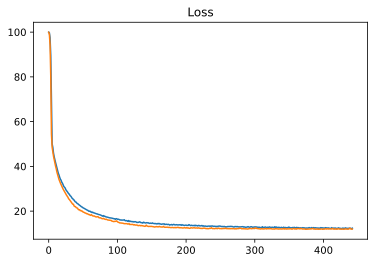

In [57]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [58]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [59]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.97%


In [60]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 5: NLP + Multiple Inputs

In [61]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [62]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [63]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [64]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.72 s, sys: 7.32 ms, total: 1.72 s
Wall time: 1.73 s


In [65]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [66]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.51 s, sys: 1.92 ms, total: 1.52 s
Wall time: 1.52 s


In [67]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [68]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [69]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [70]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [71]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [72]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [73]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [74]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )

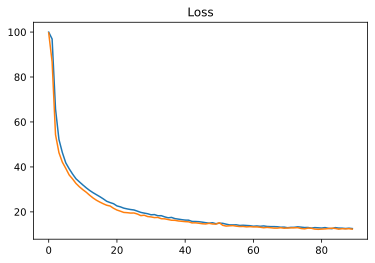

In [75]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [76]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [77]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.30%


In [78]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 6: Добавляем картинки

### Data

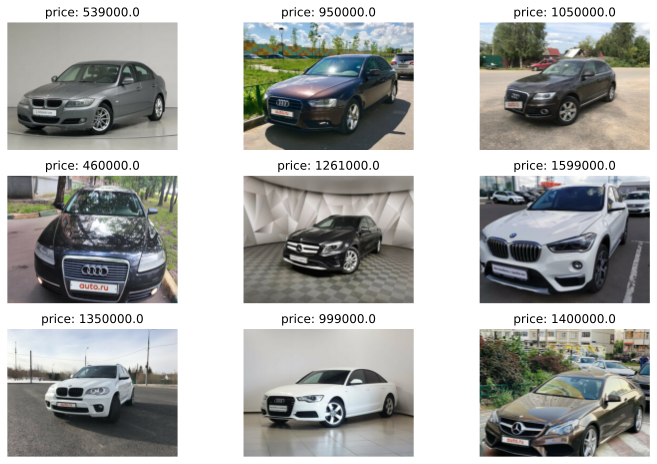

In [79]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [80]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

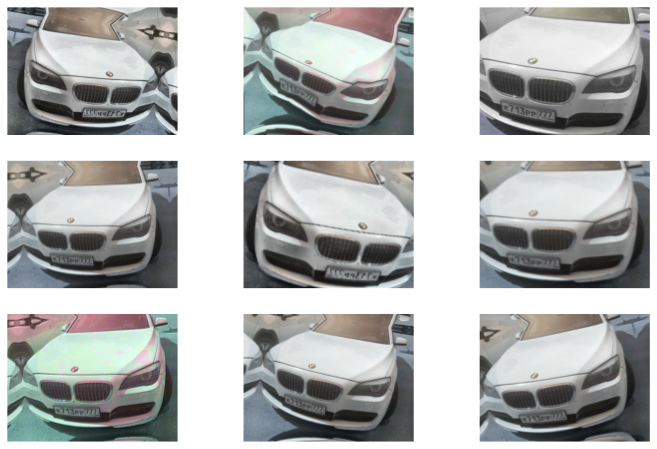

In [81]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [82]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [83]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [84]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [85]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 0us/step


In [86]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [87]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [88]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [89]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [90]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [91]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 100.0000 - MAPE: 100.00 - ETA: 1:01 - loss: 99.9999 - MAPE: 99.99 - ETA: 1:27 - loss: 99.9998 - MAPE: 99.99 - ETA: 1:39 - loss: 99.9996 - MAPE: 99.99 - ETA: 1:46 - loss: 99.9994 - MAPE: 99.99 - ETA: 1:50 - loss: 99.9991 - MAPE: 99.99 - ETA: 1:52 - loss: 99.9985 - MAPE: 99.99 - ETA: 1:54 - loss: 99.9976 - MAPE: 99.99 - ETA: 1:56 - loss: 99.9965 - MAPE: 99.99 - ETA: 1:56 - loss: 99.9953 - MAPE: 99.99 - ETA: 1:58 - loss: 99.9935 - MAPE: 99.99 - ETA: 1:59 - loss: 99.9908 - MAPE: 99.99 - ETA: 1:58 - loss: 99.9868 - MAPE: 99.98 - ETA: 1:59 - loss: 99.9827 - MAPE: 99.98 - ETA: 1:59 - loss: 99.9777 - MAPE: 99.97 - ETA: 1:59 - loss: 99.9696 - MAPE: 99.96 - ETA: 1:59 - loss: 99.9578 - MAPE: 99.95 - ETA: 1:58 - loss: 99.9492 - MAPE: 99.94 - ETA: 1:57 - loss: 99.9303 - MAPE: 99.93 - ETA: 1:57 - loss: 99.9092 - MAPE: 99.90 - ETA: 1:57 - loss: 99.8804 - MAPE: 99.88 - ETA: 1:56 - loss: 99.8443 - MAPE: 99.84 - ETA: 1:56 - loss: 99.

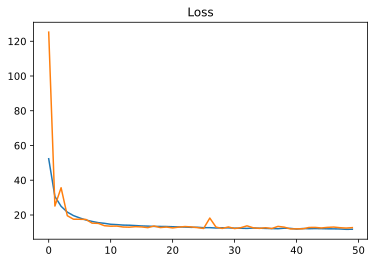

In [92]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [93]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [94]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.70%


In [95]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [96]:
autoML_submission = pd.read_csv('./autoML_submission.csv')

In [97]:
len(autoML_submission['price'].values)

1671

In [98]:
# blend_predict = (autoML_submission['price'].values + test_predict_nn3[:,0]) / 2
# print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [99]:
blend_sub_predict = (autoML_submission['price'].values + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [100]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [101]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [102]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [103]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 468)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          240128      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [104]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [105]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 100.0001 - MAPE: 100.00 - ETA: 0s - loss: 99.9900 - MAPE: 99.9900 - 0s 24ms/step - loss: 99.9900 - MAPE: 99.9900 - val_loss: 99.8780 - val_MAPE: 99.8780
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 99.8784 - MAPE: 99.87 - 0s 9ms/step - loss: 98.7800 - MAPE: 98.7800 - val_loss: 94.2467 - val_MAPE: 94.2467
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 94.5369 - MAPE: 94.53 - 0s 10ms/step - loss: 79.9731 - MAPE: 79.9731 - val_loss: 50.5628 - val_MAPE: 50.5628
Epoch 4/500
12/12 [==============================] - ETA: 0s - loss: 50.7387 - MAPE: 50.73 - 0s 9ms/step - loss: 51.4613 - MAPE: 51.4613 - val_loss: 46.7333 - val_MAPE: 46.7333
Epoch 5/500
12/12 [==============================] - ETA: 0s - loss: 47.6316 - MAPE: 47.63 - 0s 9ms/step - loss: 46.1546 - MAPE: 46.1546 - val_loss: 43.3722 - val_MAPE: 43.3722
Epoch 6/500
12/12 [==============================] - ETA: 0s - loss: 

In [106]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.46%


In [107]:
    # 